Maybe we define new structure which captures the input parameters specific to each problem in one place (`scale_factor`).
We need to define a range on `d` that is also function dependent (that we could adjust by hand). 

We need to generate three graphs: 
- Histogram of Number of `loc_min` points were found, (so outputs of the Optim routine) and what percentage of them is within a small distance of a critical point of the approximant. As a function of the degree `d` of the approximant.


In [29]:
using Pkg
using Revise 
Pkg.activate("../../.")
using Globtim
using DynamicPolynomials, DataFrames
using ProgressLogging
using Optim
using CairoMakie
CairoMakie.activate!

  Activating project at `~/globtim`


activate! (generic function with 1 method)

Can a function export "Optional attributes" like just some constants or its optimal domain of definition? --> works. 

In [2]:
params = load_function_params("Deuflhard_4d")
TR = test_input(Deuflhard_4d;
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
    tolerance=params.tolerance)

@polyvar(x[1:TR.dim]); # Define polynomial ring 

In [12]:
d_min, d_max = 2, 8

(2, 8)

In [13]:
results = analyze_degrees(TR, x, d_min, d_max, step=1, tol_dist=0.02)

current L2-norm: 25.801935970928422
Dimension m of the vector space: 15

=== Starting MSolve Parser (dimension: 4) ===
Processed 1 points (0.0s)
Processing point 1 of 1
Optimization has converged within bounds: ✓
current L2-norm: 16.21499798232248
Dimension m of the vector space: 35

=== Starting MSolve Parser (dimension: 4) ===
Processed 16 points (0.0s)
Processing point 1 of 4
Optimization has converged within bounds: ✓
Processing point 2 of 4
Optimization has converged within bounds: ✓
Processing point 3 of 4
Optimization has converged within bounds: ✓
Processing point 4 of 4
Optimization has converged within bounds: ✓
current L2-norm: 8.239501991634237
Dimension m of the vector space: 70

=== Starting MSolve Parser (dimension: 4) ===
Processed 25 points (0.0s)
Processing point 1 of 9
Optimization has converged within bounds: ✓
Processing point 2 of 9
Optimization has converged within bounds: ✓
Processing point 3 of 9
Optimization has converged within bounds: ✓
Processing point 4 of

Dict{Int64, @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTuple, discrete_l2::Float64}} with 7 entries:
  5 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTu…
  4 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTu…
  6 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTu…
  7 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTu…
  2 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTu…
  8 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTu…
  3 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTu…

In [21]:
open("output_deufl4d.jl", "w") do file
    dump(file, results)
end
# new_results = analyze_degrees(TR, x, d_min, d_max, results, tol_dist=1.)

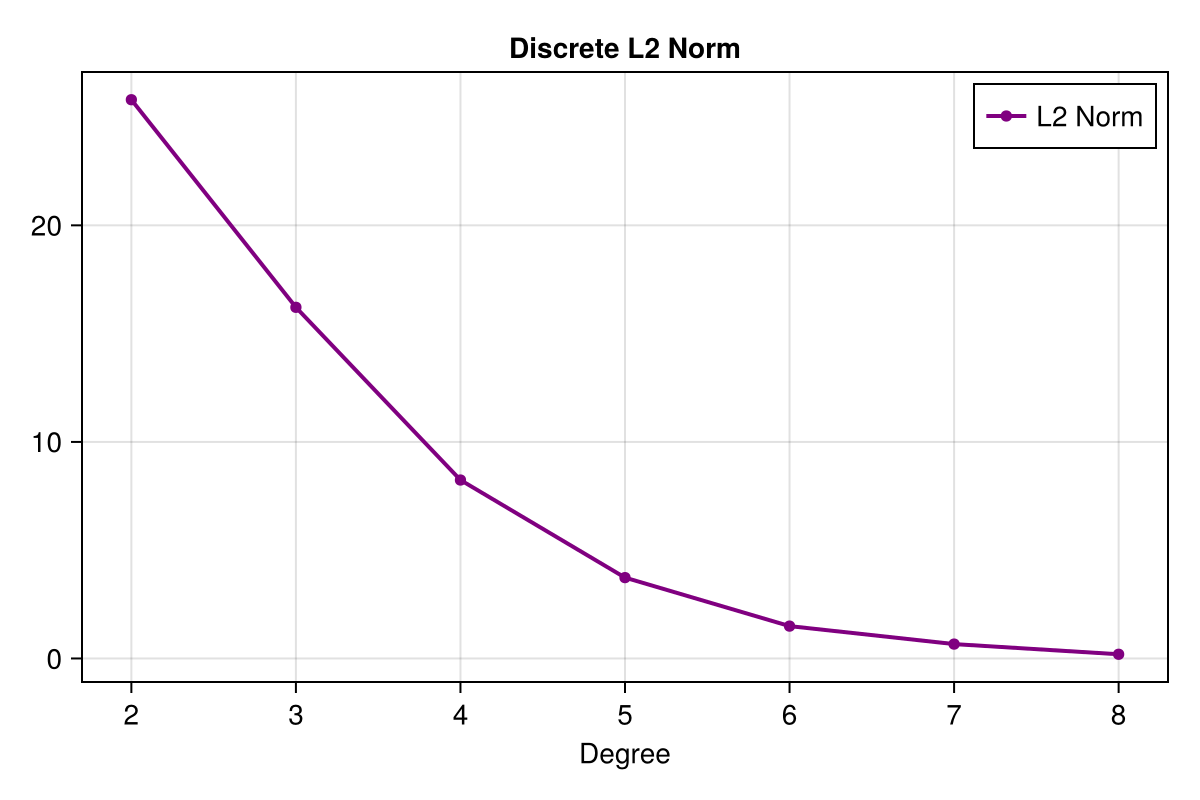

CairoMakie.Screen{IMAGE}


In [17]:
fig_1 = plot_discrete_l2(results, d_min, d_max, 1)
save("discrete_l2.pdf", fig_1)
display(fig_1)

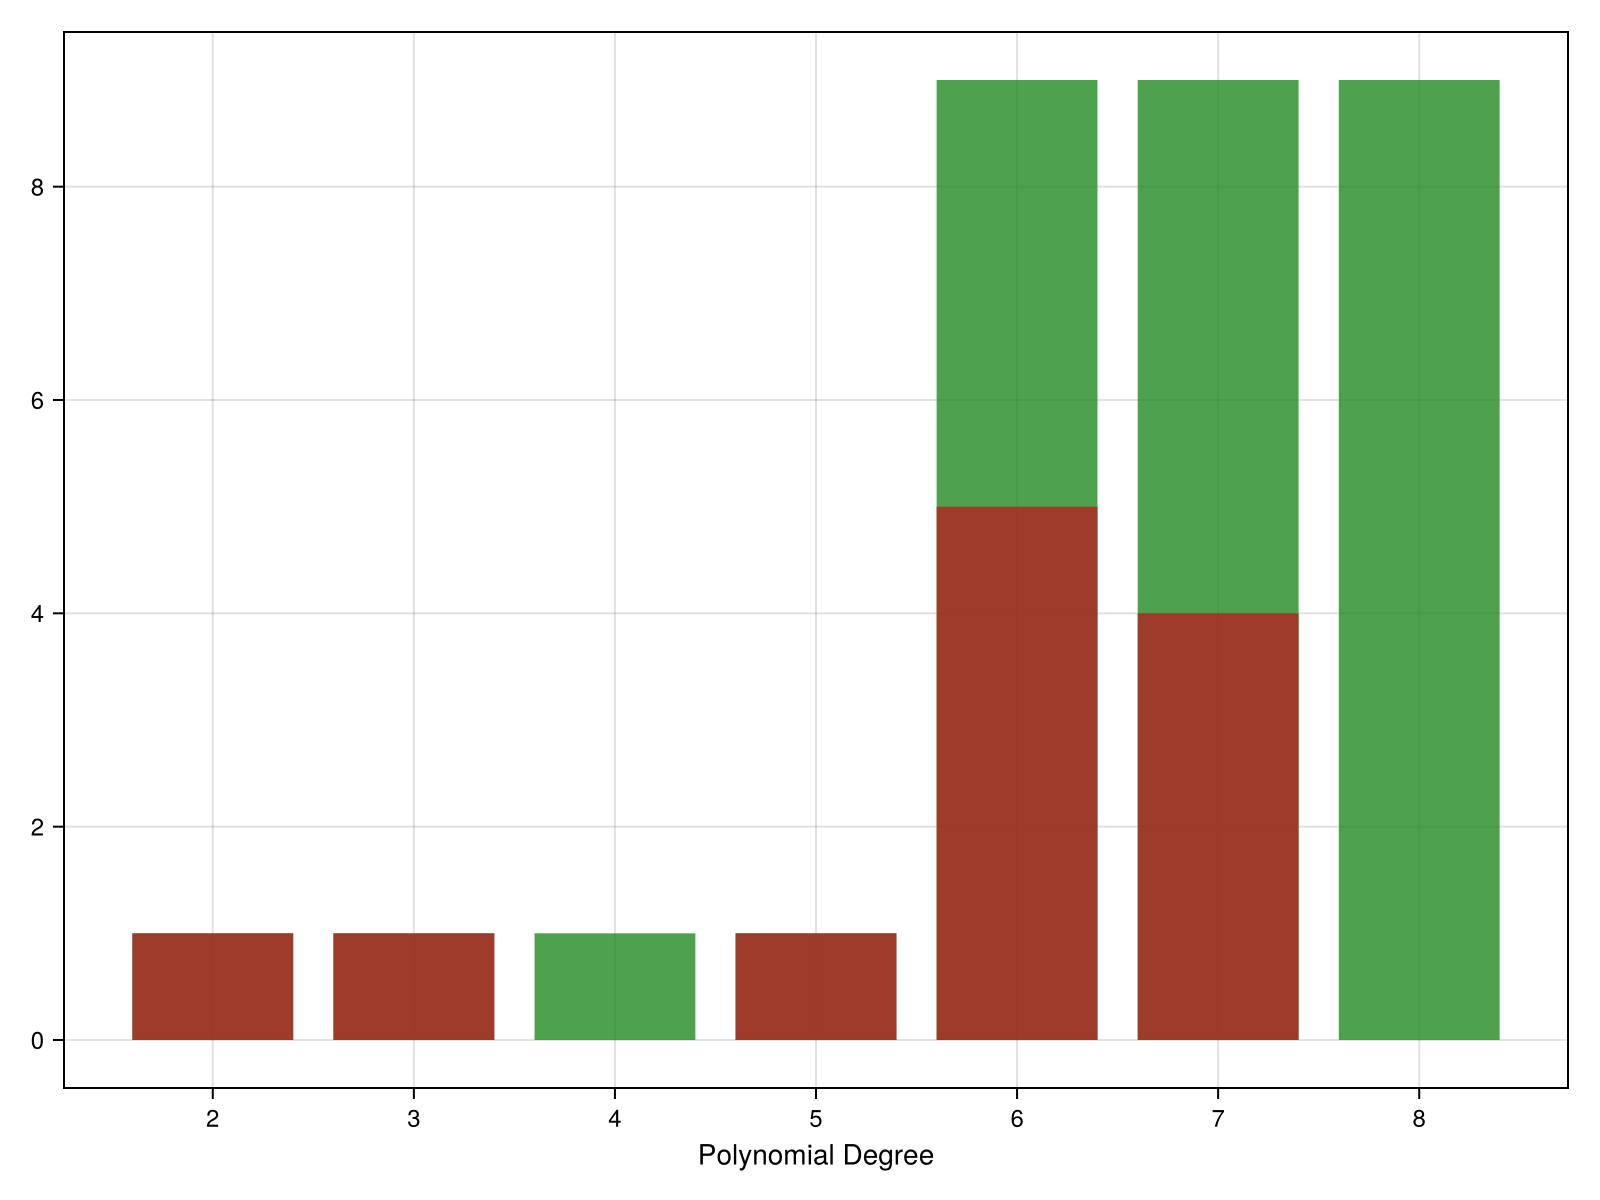

CairoMakie.Screen{IMAGE}


In [18]:
fig_2 = capture_histogram(results, d_min, d_max, 1, show_legend=false)
save("histogram.pdf", fig_2)
display(fig_2)

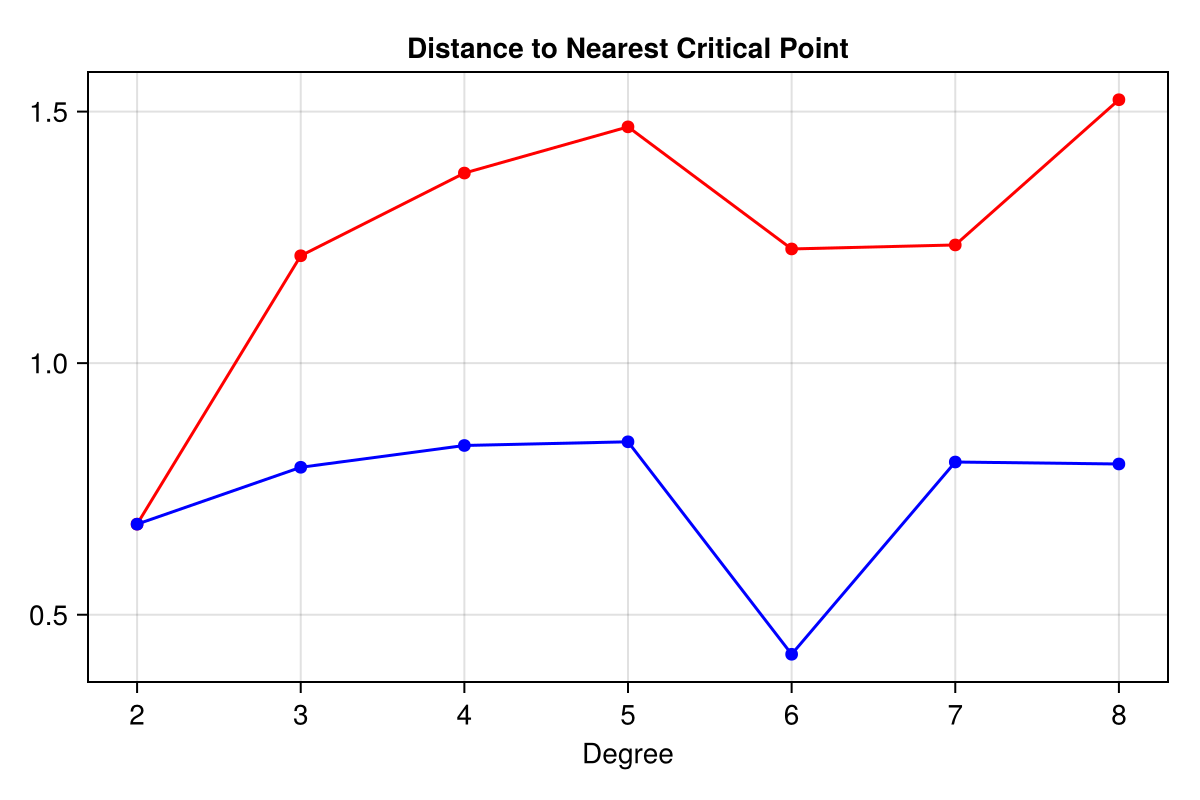

CairoMakie.Screen{IMAGE}


In [31]:
fig_3 = plot_convergence_analysis(results, d_min, d_max, 1, show_legend=false)
# save("convergence_analysis.pdf", fig_3)
display(fig_3)

In [35]:
revise(Globtim)

┌ Error: Failed to revise /Users/ghscholt/globtim/src/Globtim.jl__@require__
│   exception = (SystemError("opening file \"\"", 2, nothing), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000011987848b, Ptr{Nothing} @0x00000001194fbbdf, Ptr{Nothing} @0x00000001194f1e93, Ptr{Nothing} @0x00000001198e7207, Ptr{Nothing} @0x000000011a04162b, Ptr{Nothing} @0x0000000119ea2b73, Ptr{Nothing} @0x000000015e89bfb3])
└ @ Revise /Users/ghscholt/.julia/packages/Revise/CawM1/src/packagedef.jl:778
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /Users/ghscholt/globtim/src/Globtim.jl__@require__
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise /Users/ghscholt/.julia/packages/Revise/CawM1/src/packagedef.jl:893
┌ Warning: Replacing 

true

In [74]:
function compute_min_distances(df, df_check)
    # Initialize array to store minimum distances
    min_distances = Float64[]

    # For each row in df, find distance to closest point in df_check
    for i in 1:nrow(df)
        point = Array(df[i, :])  # Convert row to array
        min_dist = Inf

        # Compare with each point in df_check
        for j in 1:nrow(df_check)
            check_point = Array(df_check[j, :])
            dist = norm(point - check_point)  # Euclidean distance
            min_dist = min(min_dist, dist)
        end

        push!(min_distances, min_dist)
    end

    return min_distances
end

function analyze_captured_distances(df, df_check)
    distances = compute_min_distances(df, df_check)
    return (
        maximum=maximum(distances),
        average=mean(distances)
    )
end

function analyze_captured_distances(df, df_check)
    distances = compute_min_distances(df, df_check)
    return (
        maximum=maximum(distances),
        average=sum(distances) / length(distances)
    )
end

function plot_convergence_captured(results, df_check, start_degree::Int, end_degree::Int, step::Int; show_legend::Bool=true)
    degrees = start_degree:step:end_degree
    max_distances = Float64[]
    avg_distances = Float64[]

    for d in degrees
        x_cols = [col for col in names(results[d].df_min) if startswith(string(col), "x")]
        df = results[d].df_min[:, x_cols]

        stats = analyze_captured_distances(df, df_check)
        push!(max_distances, stats.maximum)
        push!(avg_distances, stats.average)
    end

    fig = Figure(size=(600, 400))

    ax = Axis(fig[1, 1],
        title="Distance to Nearest Critical Point",
        xlabel="Degree",
        ylabel="")

    scatterlines!(ax, degrees, max_distances, label="Maximum", color=:red)
    scatterlines!(ax, degrees, avg_distances, label="Average", color=:blue)

    if show_legend
        axislegend(ax)
    end

    return fig
end

plot_convergence_captured (generic function with 2 methods)

Here we need to load the collection of true critical points of the function -- `.csv` file.

In [41]:
results[8].df_min

Row,x4,x3,x2,x1,value,captured
,Float64,Float64,Float64,Float64,Float64,Bool
1,-0.741152,0.741152,-1.01625,0.256625,1.96595e-19,true
2,-1.01625,0.256625,-0.741152,0.741152,1.25597e-18,true
3,-0.741152,0.741152,-0.256625,1.01625,1.9664e-19,true
4,-1.01625,0.256625,-0.256625,1.01625,1.78691e-18,true
5,-1.01625,0.256625,-1.01625,0.256625,1.78691e-18,true
6,-0.741152,0.741152,-0.741152,0.741152,1.06757e-19,true
7,-0.256625,1.01625,-0.256625,1.01625,2.84246e-19,true
8,-0.256625,1.01625,-0.741152,0.741152,1.91338e-19,true
9,-0.256625,1.01625,-1.01625,0.256625,2.84611e-19,true


In [49]:
# Compute the tensored 4d dataframe #
using IterTools
function double_dataframe(df::DataFrame)
    n = nrow(df)
    pairs = collect(product(1:n, 1:n))

    x1 = vec([df.x[j[1]] for j in pairs])
    y1 = vec([df.y[j[1]] for j in pairs])
    x2 = vec([df.x[j[2]] for j in pairs])
    y2 = vec([df.y[j[2]] for j in pairs])

    return DataFrame(x1=x1, x2=y1, x3=x2, x4=y2)
end

double_dataframe (generic function with 1 method)

In [ ]:
using CSV
df_chebfun = CSV.read("../../data/matlab_critical_points/valid_points_deuflhard.csv", DataFrame)
df_4d = double_dataframe(df_chebfun);

The issue here is that we measure the distance from the optimized points to optimized points. Now we would like it to go backwards. 
We need to generate by hand a dataframe with only the six critical points of interest, maybe even one with just the 3 local minimizers. 

Then we take every point in `df_check` and compute the closest neighbor in `results` (the outputs by degree).

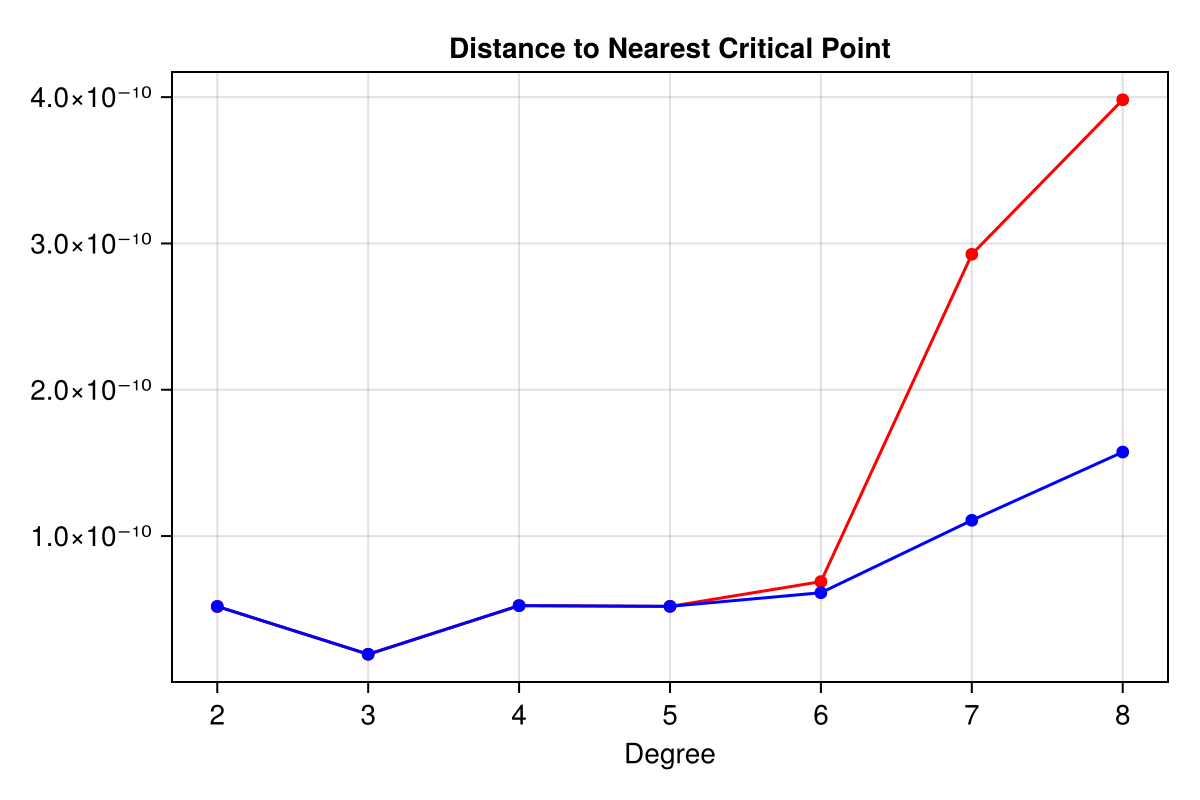

In [75]:
using LinearAlgebra
fig_4 = plot_convergence_captured(results, df_4d, d_min, d_max, 1, show_legend=false)

In [ ]:
# save("convergence_captured_deufl4d.pdf", fig_4)

CairoMakie.Screen{PDF}


Trying to extract only the information we need from the doubled dataframe.
It is probably after doubling the dataframe that we want to sort through the data. For instance 
- []:only keep critical points inside the domain. 
- []:local minimizers by sorting through `z` values (function evaluations).

In [82]:
function points_in_hypercube(df::DataFrame, TR)
    # Count x-columns to determine dimensionality
    n_dims = count(col -> startswith(string(col), "x"), names(df))

    # Create boolean array for results
    in_cube = trues(nrow(df))

    # Check each point
    for i in 1:nrow(df)
        for j in 1:n_dims
            if abs(df[i, Symbol("x$j")] - TR.center[j]) > TR.sample_range
                in_cube[i] = false
                break
            end
        end
    end

    return in_cube
end

points_in_hypercube (generic function with 2 methods)

In [86]:
function points_in_range(df::DataFrame, TR, value_range::Float64)
    # Count x-columns to determine dimensionality
    n_dims = count(col -> startswith(string(col), "x"), names(df))

    # Create boolean array for results
    in_range = falses(nrow(df))

    # Reference value (minimum found so far)
    min_val = minimum(df.z)

    # Check each point's function evaluation
    for i in 1:nrow(df)
        point = [df[i, Symbol("x$j")] for j in 1:n_dims]
        val = TR.objective(point)
        if abs(val - min_val) ≤ value_range
            in_range[i] = true
        end
    end

    return in_range
end

points_in_range (generic function with 1 method)

In [99]:
DF = results[8].df
inside_mask = points_in_hypercube(DF, TR)
df_inside = DF[inside_mask, :]
sort!(df_inside, :z);
value_mask = points_in_range(df_inside, TR, 0.1)
df_minimizers = df_inside[value_mask, :] # has both `x` (raw) and `y` (optimized)

Row,x1,x2,x3,x4,z,y1,y2,y3,y4,close,steps,converged
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Float64,Bool
1,0.250298,-1.02005,1.02005,-0.250298,0.00220179,0.256625,-1.01625,1.01625,-0.256625,true,6.0,true
2,1.02005,-0.250298,0.250298,-1.02005,0.00220179,1.01625,-0.256625,0.256625,-1.01625,true,6.0,true
3,0.250298,-1.02005,0.250298,-1.02005,0.00220179,0.256625,-1.01625,0.256625,-1.01625,true,6.0,true
4,1.02005,-0.250298,1.02005,-0.250298,0.00220179,1.01625,-0.256625,1.01625,-0.256625,true,7.0,true
5,0.732914,-0.732914,0.250298,-1.02005,0.00628259,0.741152,-0.741152,0.256625,-1.01625,true,7.0,true
6,0.732914,-0.732914,1.02005,-0.250298,0.00628259,0.741152,-0.741152,1.01625,-0.256625,true,7.0,true
7,0.250298,-1.02005,0.732914,-0.732914,0.00628259,0.256625,-1.01625,0.741152,-0.741152,true,7.0,true
8,1.02005,-0.250298,0.732914,-0.732914,0.00628259,1.01625,-0.256625,0.741152,-0.741152,true,7.0,true
9,0.732914,-0.732914,0.732914,-0.732914,0.0103634,0.741152,-0.741152,0.741152,-0.741152,true,3.0,true


Now we collect the local minimizers in that specific subdomain. 
~Then we will compare the original `df`'s with this new `df_check`'s.~

In [124]:
function plot_filtered_y_distances(
    df_filtered::DataFrame,
    results::Dict{Int,NamedTuple{(:df, :df_min, :convergence_stats, :discrete_l2),
        Tuple{DataFrame,DataFrame,NamedTuple,Float64}}},
    start_degree::Int,
    end_degree::Int,
    step::Int=1;
    use_optimized::Bool=true,  # true for y values (optimized), false for x values (initial)
    show_legend::Bool=true)

    degrees = start_degree:step:end_degree
    n_dims = count(col -> startswith(string(col), "x"), names(df_filtered))
    n_points = nrow(df_filtered)

    # ANSI color codes for pretty printing
    bold = "\e[1m"
    blue = "\e[34m"
    green = "\e[32m"
    reset = "\e[0m"

    point_type = use_optimized ? "optimized (y)" : "initial (x)"
    println("\n$(bold)Distance Analysis Summary$(reset)")
    println("$(blue)▶ $(reset)Analyzing $(bold)$(n_points)$(reset) filtered points in $(bold)$(n_dims)$(reset) dimensions")
    println("$(blue)▶ $(reset)Using $(bold)$point_type$(reset) points from filtered data")
    println("$(blue)▶ $(reset)Degree range: $(bold)$start_degree$(reset) to $(bold)$end_degree$(reset) with step $(bold)$step$(reset)")

    point_distances = zeros(Float64, n_points, length(degrees))

    for (i, row) in enumerate(eachrow(df_filtered))
        # Select either y (optimized) or x (initial) values based on flag
        point_coords::Vector{Float64} = if use_optimized
            [row[Symbol("y$j")] for j in 1:n_dims]
        else
            [row[Symbol("x$j")] for j in 1:n_dims]
        end

        for (d_idx, d) in enumerate(degrees)
            raw_points = results[d].df

            min_dist::Float64 = Inf
            for raw_row in eachrow(raw_points)
                point::Vector{Float64} = [raw_row[Symbol("x$j")] for j in 1:n_dims]
                dist::Float64 = norm(point_coords - point)
                min_dist = min(min_dist, dist)
            end
            point_distances[i, d_idx] = min_dist
        end
    end

    max_distances::Vector{Float64} = [maximum(point_distances[:, i]) for i in 1:length(degrees)]
    avg_distances::Vector{Float64} = [sum(point_distances[:, i]) / n_points for i in 1:length(degrees)]
    min_distances::Vector{Float64} = [minimum(point_distances[:, i]) for i in 1:length(degrees)]
    overall_avg::Float64 = sum(avg_distances) / length(avg_distances)

    println("\n$(green)▶ $(reset)Distance Statistics:")
    println("   $(bold)Overall maximum distance:$(reset) $(round(maximum(max_distances), digits=6))")
    println("   $(bold)Overall minimum distance:$(reset) $(round(minimum(min_distances), digits=6))")
    println("   $(bold)Overall average distance:$(reset) $(round(overall_avg, digits=6))")

    println("\n$(green)▶ $(reset)Per-degree Analysis:")
    for (i, d) in enumerate(degrees)
        println("   $(bold)Degree $d:$(reset)")
        println("      Max distance: $(round(max_distances[i], digits=6))")
        println("      Min distance: $(round(min_distances[i], digits=6))")
        println("      Avg distance: $(round(avg_distances[i], digits=6))")
        println()
    end

    fig = Figure(size=(600, 400))

    point_label = use_optimized ? "Optimized" : "Initial"
    ax = Axis(fig[1, 1],
        # title="Distance from Each $point_label Point to Nearest Initial Point",
        xlabel="Degree",
        ylabel="")

    scatterlines!(ax, degrees, max_distances, label="Maximum", color=:red)
    scatterlines!(ax, degrees, avg_distances, label="Average", color=:blue)

    if show_legend
        axislegend(ax)
    end

    return fig
end

plot_filtered_y_distances (generic function with 3 methods)

Raw data from the approximant $w_{d, S}$  is used to test against.    


Distance Analysis Summary
▶ Analyzing 9 filtered points in 4 dimensions
▶ Using optimized (y) points from filtered data
▶ Degree range: 2 to 8 with step 1

▶ Distance Statistics:
   Overall maximum distance: 0.893556
   Overall minimum distance: 0.006838
   Overall average distance: 0.391974

▶ Per-degree Analysis:
   Degree 2:
      Max distance: 0.893556
      Min distance: 0.679984
      Avg distance: 0.825571

   Degree 3:
      Max distance: 0.759646
      Min distance: 0.215656
      Avg distance: 0.60975

   Degree 4:
      Max distance: 0.790679
      Min distance: 0.009998
      Avg distance: 0.60103

   Degree 5:
      Max distance: 0.819816
      Min distance: 0.098908
      Avg distance: 0.634864

   Degree 6:
      Max distance: 0.086737
      Min distance: 0.01068
      Avg distance: 0.041849

   Degree 7:
      Max distance: 0.022508
      Min distance: 0.006838
      Avg distance: 0.018156

   Degree 8:
      Max distance: 0.016476
      Min distance: 0.01044
      Avg

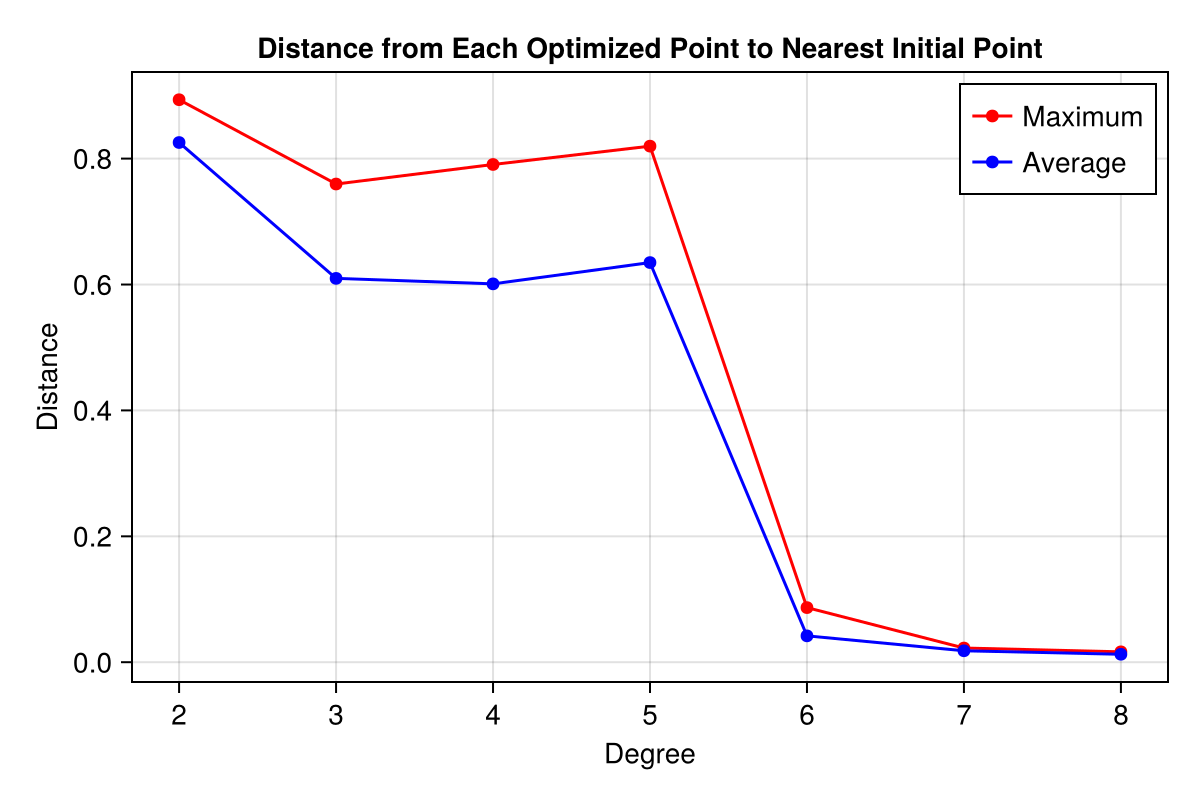

In [119]:
fig_5 = plot_filtered_y_distances(df_minimizers, results, d_min, d_max, 1)
# save("filtered_y_distances_deufl4d.pdf", fig_5)

In this case, we are looking for all the critical points of `f` that should be in the domain of `w_{d, S}`. A couple of the critical points that are not local minimizers we have trouble capturing.  


Distance Analysis Summary
▶ Analyzing 36 filtered points in 4 dimensions
▶ Using initial (x) points from filtered data
▶ Degree range: 2 to 8 with step 1

▶ Distance Statistics:
   Overall maximum distance: 0.893556
   Overall minimum distance: 0.006838
   Overall average distance: 0.361435

▶ Per-degree Analysis:
   Degree 2:
      Max distance: 0.893556
      Min distance: 0.679984
      Avg distance: 0.795266

   Degree 3:
      Max distance: 0.759646
      Min distance: 0.215656
      Avg distance: 0.50247

   Degree 4:
      Max distance: 0.790679
      Min distance: 0.009998
      Avg distance: 0.472919

   Degree 5:
      Max distance: 0.819816
      Min distance: 0.01269
      Avg distance: 0.492264

   Degree 6:
      Max distance: 0.11615
      Min distance: 0.01068
      Avg distance: 0.072908

   Degree 7:
      Max distance: 0.360886
      Min distance: 0.006838
      Avg distance: 0.170283

   Degree 8:
      Max distance: 0.063638
      Min distance: 0.01044
      Avg d

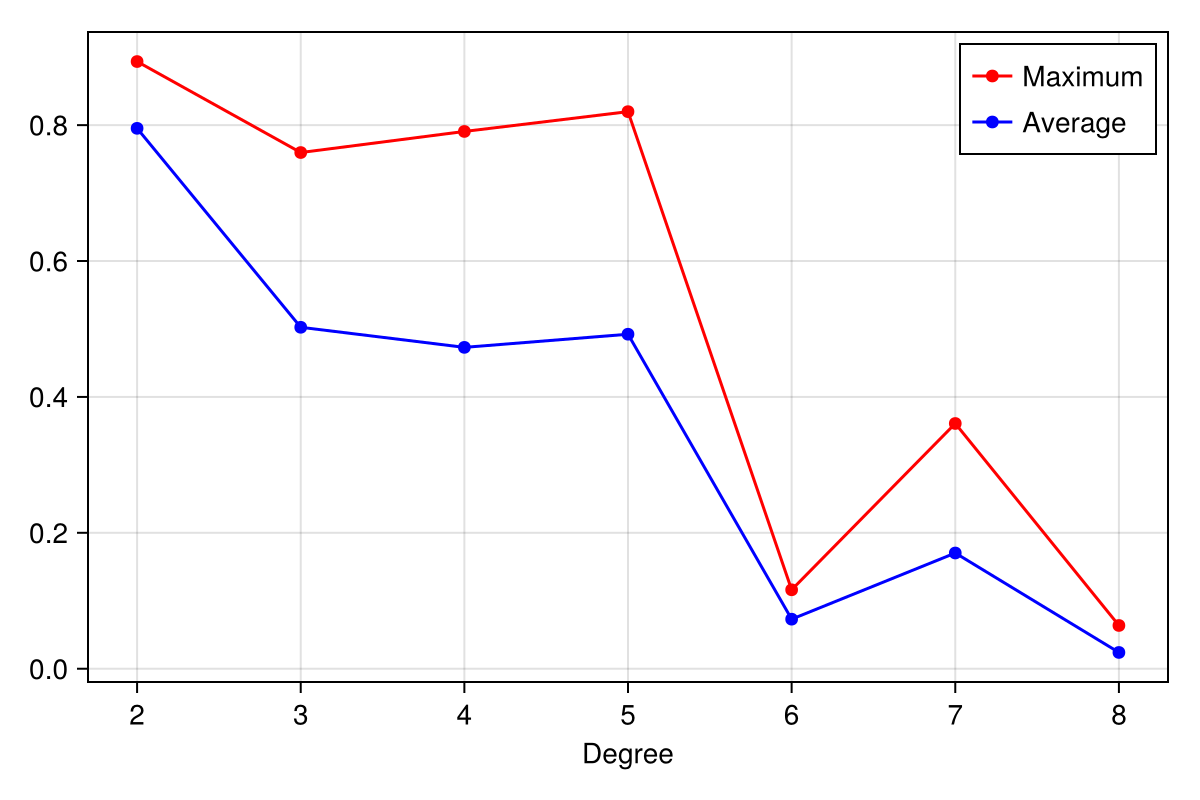

In [125]:
mask_int = points_in_hypercube(df_4d, TR)
df_int = df_4d[mask_int, :]
fig_6 = plot_filtered_y_distances(df_int, results, d_min, d_max, 1, use_optimized=false)